# Two port parameters
Last update: 26 Apr 2022  

This notebook describes the calculation of two port impedance parameters derived from the circuit's netlist. A [Two-port network](https://en.wikipedia.org/wiki/Two-port_network) is a circuit that has two pairs of ports or terminals and the circuit is characterized by the currents and voltages at the ports by a 2 by 2 matrix. From a two port matrix the response of the network to signals applied to the ports to be calculated easily, without solving for all the internal voltages and currents in the network. For example filters, matching networks, transmission lines, and transistors are characterized by two port paramters.

The first circuit is an antennuator, which could be easily analyized by hand with a pencil, paper and a calculator, but here I'm using python to step through the calculations. These same steps can be applied to larger, more complex circuits which would be difficult to analyze by hand. The second circuit is a bandpass filter. The Sympy and SciPy libraries can be used to obtain symbolic and numerical results, however as is shown below, when the circuit is large, symbolic results are not that useful nor do they provid much insight.

The procedure starts by first drawing a schematic of the circuit with a schematic capture program such as EasyEDA (links to the schematics are provided below) then the netlist is generated and exported as a text file. The netlist is used to generate modified nodal equations with the python program described [here](https://github.com/Tiburonboy/Symbolic-modified-nodal-analysis). The equations are solved for voltages and currents at the port terminals by using SymPy to generate the z-paramters [z-paramters](https://en.wikipedia.org/wiki/Impedance_parameters). Z-parameters are also known as open-circuit impedance parameters as they are calculated under open circuit conditions. Once the z-paramters are obtained, these can be converted into other paramters, such as Y, H, S or others. 

The second circuit is a band pass filter. The filter is designed from a low pass prototype by using normalized values from a filter design handbook.  

Todo:  
- clean up narative
- spell check
- write abstract for blog
 - intro, schematics, 
- Need to revisit polarity on voltage and current sources, which direction is positive.  

Blog post  
Title: Two port network  
Abstract:  
copy intro from above




To view the notebook click here to open the notebook viewer.

The JupyterLab notebook is located on github, click here to following the link to the repository.

In [1]:
import numpy as np
from sympy import *
from scipy import signal
import matplotlib.pyplot as plt
init_printing()

## Pi-attenuator
The pi-attenuator is formed by three resistors with R1 and R3 as the shunt resistors on the input and output ports and R2 as the series resistor in a circuit topology in the shape of the greek letter pi. For R1 = R3 = 96.25 ohms and R2 equal to 71.15 ohms, the attenuation is 10 dB and the port impedance is 50 ohms. Pasternack's Pi Attenuator Calculator ([Pi pad attenuator](https://www.pasternack.com/t-calculator-pi-attn.aspx)) was used to design the attenuator.

The selectoipn of which type a network parameter is somewhat a matter of convienece. However, some circuits can't ve shorted ot left open so s-paramters are an option. Salveing for the z-paramters is convient since all we need to to is reove yhe load or source to set the current at the port to zero.

To find Z-parameters attach voltage sources to both ports and find the node equations. EasyEDA was used to draw the schematic and generate the netlist. A link to the schematic is [here](https://easyeda.com/editor#id=|6b1460bfe8ec4872b7d7fd3038f38331|82658727399e487c94ebe177746e0ba0).

![schematic](sch_pi_atten_10dB_50ohm.png)

The netlist for the circuit:
~~~
R1 0 1 96.25
R2 1 2 71.15
R3 0 2 96.25
V1 1 0 1
V2 2 0 1
~~~

### Find z11 & z21
To find $z_{11}$ and $z_{21}$, remove V2 from net list by commenting out the V2 line in the net list. This will make $I_2$ equal to zero. $z_{11}$ is equal to $\frac{V_1}{I_1}\text{  when  }I_2=0$ and $z_{21}$ is equal to $\frac{V_2}{I_1}\text{  when  }I_2=0$.  

The net list below was run through the NMA code to generate the circuit equations.
~~~
R1 0 1 96.25
R2 1 2 71.15
R3 0 2 96.25
V1 1 0 1
*V2 2 0 1
~~~

The circuit equations generated are:
~~~
[[Eq(I_V1 + v1*(1/R2 + 1/R1) - v2/R2, 0)],
[Eq(v2*(1/R3 + 1/R2) - v1/R2, 0)],
[Eq(v1, V1)]]
~~~

In [2]:
# declare the following symbols
I_V1, R3, R2, V1, v1, R1, v2 = symbols('I_V1 R3 R2 V1 v1 R1 v2')

# use the equations generated by nodal analysis
equ_p1 = Matrix(
    [[Eq(I_V1 + v1*(1/R2 + 1/R1) - v2/R2, 0)],
    [Eq(v2*(1/R3 + 1/R2) - v1/R2, 0)],
    [Eq(v1, V1)]])
equ_p1

⎡          ⎛1    1 ⎞   v₂    ⎤
⎢I_V1 + v₁⋅⎜── + ──⎟ - ── = 0⎥
⎢          ⎝R₂   R₁⎠   R₂    ⎥
⎢                            ⎥
⎢      ⎛1    1 ⎞   v₁        ⎥
⎢   v₂⋅⎜── + ──⎟ - ── = 0    ⎥
⎢      ⎝R₃   R₂⎠   R₂        ⎥
⎢                            ⎥
⎣          v₁ = V₁           ⎦

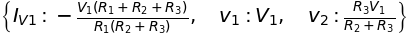

In [3]:
# find symbolic solution
u_p1 = solve(equ_p1,[v1, v2, I_V1])
u_p1

$z_{11} = \frac {V_1}{I_1} \text{  when  } I_2=0$  
# comment on neg sign

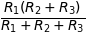

In [4]:
z11 = -u_p1[v1]/u_p1[I_V1]
z11

$z_{21} = \frac {V_2}{I_1} \text{  when  } I_2=0$  

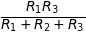

In [5]:
z21 = -u_p1[v2]/u_p1[I_V1]
z21

### Find z12 & z22
To find $z_{12}$ and $z_{22}$, remove V1 from net list by commenting out the V1 line in the netlist. This will make $I_1$ equal to zero. $z_{12}$ is equal to $\frac{V_1}{I_2}\text{  when  }I_1=0$ and $z_{22}$ is equal to $\frac{V_2}{I_2}\text{  when  }I_1=0$.  

The net list below was run through the NMA code to generate the circuit equations.

Remove V1 from net list.
~~~
R1 0 1 96.25
R2 1 2 71.15
R3 0 2 96.25
*V1 1 0 1
V2 2 0 1
~~~

The circuit equations generated by the MNA python code.
~~~
[[Eq(v1*(1/R2 + 1/R1) - v2/R2, 0)],
[Eq(I_V2 + v2*(1/R3 + 1/R2) - v1/R2, 0)],
[Eq(v2, V2)]]
~~~

In [6]:
# declare the following symbols
R3, R2, V2, v1, R1, I_V2, v2 = symbols('R3 R2 V2 v1 R1 I_V2 v2')

# use the equations generated by nodal analysis
equ_p2 = Matrix(
    [[Eq(v1*(1/R2 + 1/R1) - v2/R2, 0)],
    [Eq(I_V2 + v2*(1/R3 + 1/R2) - v1/R2, 0)],
    [Eq(v2, V2)]])
equ_p2

⎡      ⎛1    1 ⎞   v₂        ⎤
⎢   v₁⋅⎜── + ──⎟ - ── = 0    ⎥
⎢      ⎝R₂   R₁⎠   R₂        ⎥
⎢                            ⎥
⎢          ⎛1    1 ⎞   v₁    ⎥
⎢I_V2 + v₂⋅⎜── + ──⎟ - ── = 0⎥
⎢          ⎝R₃   R₂⎠   R₂    ⎥
⎢                            ⎥
⎣          v₂ = V₂           ⎦

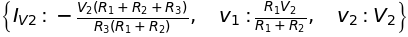

In [7]:
# find symbolic solution
u_p2 = solve(equ_p2,[v1, v2, I_V2])
u_p2

$z_{12}=\frac{V_1}{I_2}\text{  when  }I_1=0$ 

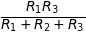

In [8]:
z12 = -u_p2[v1]/u_p2[I_V2]
z12

$z_{22}=\frac{V_2}{I_2}\text{  when  }I_1=0$  

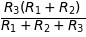

In [9]:
z22 = -u_p2[v2]/u_p2[I_V2]
z22

The elements of the matrix can be displayed:

In [10]:
Matrix([[z11,z21],[z12,z22]])

⎡R₁⋅(R₂ + R₃)     R₁⋅R₃    ⎤
⎢────────────  ────────────⎥
⎢R₁ + R₂ + R₃  R₁ + R₂ + R₃⎥
⎢                          ⎥
⎢   R₁⋅R₃      R₃⋅(R₁ + R₂)⎥
⎢────────────  ────────────⎥
⎣R₁ + R₂ + R₃  R₁ + R₂ + R₃⎦

Actual values for each of the components can be substituted for the symbols with R1 = R3 = 96.25 ohms and R2 equal to 71.15 ohms

In [11]:
atten_values = {R1:96.25,R2:71.15,R3:96.25}

In [12]:
z11_val = z11.subs(atten_values)
z12_val = z12.subs(atten_values)
z21_val = z21.subs(atten_values)
z22_val = z22.subs(atten_values)

The numberic values of the impedance matrix

In [72]:
np.array([[z11_val, z12_val],[z21_val, z22_val]],dtype=np.float)

array([[61.11227005, 35.13772995],
       [35.13772995, 61.11227005]])

# put the stuff here about solving for V1, V2, I1 and I2.


z11: input driving point impedance  
z12: reverse transfer impedance  
z21: forward transfer impedance  
z22: output driving point impedance   


Analysis in terms of Z https://www.ee.nthu.edu.tw/~sdyang/Courses/Circuits/Ch18_Std.pdf

$\begin{align*}
\begin{bmatrix} -1 & 0 & z11 & z12 \\\ 0 & -1 & z21 & z22 \\\ 1 & 0 & Z_S & 0 \\\ 0 & 1 & 0 & Z_L    
\end{bmatrix}
\begin{bmatrix}
  V_1  \\
  V_2  \\
  I_1 \\
  I_2
\end{bmatrix}
{} &= \begin{bmatrix}
  0  \\
  0  \\
  V_g \\
  0
\end{bmatrix}
\end{align*}$

Putting into SymPy  

In [14]:
#I_V1, R3, R2, V1, v1, R1, v2 = symbols('I_V1 R3 R2 V1 v1 R1 v2')
Z_s, Z_l, Vg = symbols('Z_s Z_l Vg')

Matrix([[-1,0,z11,z12],[0,-1,z21,z22],[1,0,Z_s,0],[0,1,0,Z_l]])

⎡        R₁⋅(R₂ + R₃)     R₁⋅R₃    ⎤
⎢-1  0   ────────────  ────────────⎥
⎢        R₁ + R₂ + R₃  R₁ + R₂ + R₃⎥
⎢                                  ⎥
⎢           R₁⋅R₃      R₃⋅(R₁ + R₂)⎥
⎢0   -1  ────────────  ────────────⎥
⎢        R₁ + R₂ + R₃  R₁ + R₂ + R₃⎥
⎢                                  ⎥
⎢1   0        Zₛ            0      ⎥
⎢                                  ⎥
⎣0   1        0             Zₗ     ⎦

In [15]:
Matrix([V1,V2,I_V1,I_V2])

⎡ V₁ ⎤
⎢    ⎥
⎢ V₂ ⎥
⎢    ⎥
⎢I_V1⎥
⎢    ⎥
⎣I_V2⎦

In [16]:
Matrix([0,0,Vg,0])

⎡0 ⎤
⎢  ⎥
⎢0 ⎥
⎢  ⎥
⎢Vg⎥
⎢  ⎥
⎣0 ⎦

In [17]:
eq1 = Eq(Matrix([[-1,0,z11,z12],[0,-1,z21,z22],[1,0,Z_s,0],[0,1,0,Z_l]])*Matrix([V1,V2,I_V1,I_V2]),Matrix([0,0,Vg,0]))
eq1

⎡I_V1⋅R₁⋅(R₂ + R₃)    I_V2⋅R₁⋅R₃      ⎤       
⎢───────────────── + ──────────── - V₁⎥       
⎢   R₁ + R₂ + R₃     R₁ + R₂ + R₃     ⎥   ⎡0 ⎤
⎢                                     ⎥   ⎢  ⎥
⎢ I_V1⋅R₁⋅R₃    I_V2⋅R₃⋅(R₁ + R₂)     ⎥   ⎢0 ⎥
⎢──────────── + ───────────────── - V₂⎥ = ⎢  ⎥
⎢R₁ + R₂ + R₃      R₁ + R₂ + R₃       ⎥   ⎢Vg⎥
⎢                                     ⎥   ⎢  ⎥
⎢            I_V1⋅Zₛ + V₁             ⎥   ⎣0 ⎦
⎢                                     ⎥       
⎣            I_V2⋅Zₗ + V₂             ⎦       

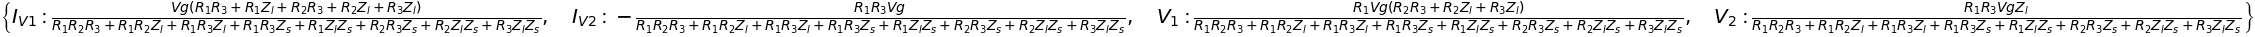

In [18]:
ans1 = solve(eq1,[V1, V2, I_V1,I_V2])
ans1

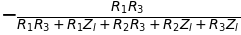

In [19]:
# current gain
ans1[I_V2]/ans1[I_V1]

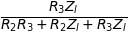

In [20]:
# voltage gain
ans1[V2]/ans1[V1]

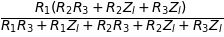

In [21]:
# Z input
ans1[V1]/ans1[I_V1]

In [22]:
# Z out
ans1[V2]/ans1[I_V2]

Re do in terms of z-parameters

In [23]:
Z11, Z12, Z21, Z22 = symbols('Z11 Z12 Z21 Z22')

In [24]:
eqZ = Eq(Matrix([[-1,0,Z11,Z12],[0,-1,Z21,Z22],[1,0,Z_s,0],[0,1,0,Z_l]])*Matrix([V1,V2,I_V1,I_V2]),Matrix([0,0,Vg,0]))
eqZ

⎡I_V1⋅Z₁₁ + I_V2⋅Z₁₂ - V₁⎤   ⎡0 ⎤
⎢                        ⎥   ⎢  ⎥
⎢I_V1⋅Z₂₁ + I_V2⋅Z₂₂ - V₂⎥   ⎢0 ⎥
⎢                        ⎥ = ⎢  ⎥
⎢      I_V1⋅Zₛ + V₁      ⎥   ⎢Vg⎥
⎢                        ⎥   ⎢  ⎥
⎣      I_V2⋅Zₗ + V₂      ⎦   ⎣0 ⎦

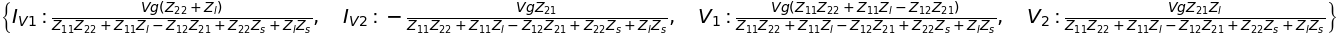

In [25]:
ansZ = solve(eqZ,[V1, V2, I_V1,I_V2])
ansZ

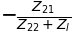

In [26]:
# current gain
ansZ[I_V2]/ansZ[I_V1]

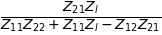

In [27]:
# voltage gain
ansZ[V2]/ansZ[V1]

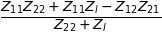

In [28]:
# Z input
ansZ[V1]/ansZ[I_V1]

In [29]:
# Z out
ansZ[V2]/ansZ[I_V2]

Sympy returns the output impedance as simply $-Z_l$, since this is the algebraic simplication of the equations. Most text books will give the output impedance in terms of the z-paramters and the source impedance. 

## calculate zin and z out, ki and kv

The input impedance of a two-port network is given by:

$Z_{in}=Z_{11}-\frac{Z_{12}Z_{21}}{Z_{22}+Z_{L}}$

where $Z_{L}$ is the impedance of the load connected to port two.

Similarly, the output impedance is given by:

$Z_{out}=Z_{22}-\frac{Z_{12}Z_{21}}{Z_{11}+Z_{S}}$

where $Z_{S}$ is the impedance of the source connected to port one.

Voltage gain  
$K_v=\frac{Z_{21}Z_{L}}{\Delta _Z+Z_{11}Z_L}$

Also forward voltage gain   
$s_{21} = \frac {2Z_{21}Z_o} {\Delta Z}$  

Current gain  
$K_i=\frac{-Z_{21}}{Z_{22}+Z_L}$

## See table 4.2, page 137, Active Network Theory for circuit properties.

plt.plot(w/(2*np.pi)/1e6, np.abs(func_z11_s(1j*w)-(func_z12_s(1j*w)*func_z21_s(1j*w))/(func_z22_s(1j*w)+Zl)),'-',label='|Zin|')
plt.plot(w/(2*np.pi)/1e6, np.abs(func_z22_s(1j*w)-(func_z12_s(1j*w)*func_z21_s(1j*w))/(func_z11_s(1j*w)+Zs)),'-',label='|Zout|')
#plt.plot(w/(2*np.pi)/1e6, np.abs(Ki),'-',label='Ki')
#plt.plot(w/(2*np.pi)/1e6, np.abs(Kv),'-',label='Kv')
Ki = (-func_z21_s(1j*w))/( func_z22_s(1j*w)+Zl)
Kv = (func_z21_s(1j*w)*Zl)/((func_z11_s(1j*w)*func_z22_s(1j*w) - func_z12_s(1j*w)*func_z21_s(1j*w)) + func_z11_s(1j*w)*Zl)

In [71]:
# Zin
Zl = 50 # load impedance
print('input impedance of newtork from z-parameters: {:.2f}'.format(np.abs(z11_val-(z12_val*z21_val)/(z22_val+Zl))))

input impedance of newtork from z-parameters: 50.00


In [70]:
# Zout
Zs = 50 # source impedance
print('output impedance of newtork from z-parameters: {:.2f}'.format(np.abs(z22_val-(z12_val*z21_val)/(z11_val+Zs))))

output impedance of newtork from z-parameters: 50.00


# why need to take abs??
What does Ki and Kv really mean??

what about power gain??  

Since these Kv and Ki are not workiong we could solve the newtork equations for the correnct expression. Would need to include the source and load resistors

BPF below has the source and load resistors in the netlist.  Are they needed? The schematic has them, but they are not in the netlist.

What direction does the current flow, maybe that why a neg sign is needed.

In [32]:
#Ki
-z21_val/(z22_val+Zl)

In [33]:
#Ki
20*np.log10(np.abs(float((-z21_val/(z22_val+Zl)))))

In [34]:
#Kv
(z21_val*Zl)/(z11_val*z22_val - z12_val*z21_val + z11_val*Zl)

In [35]:
#Kv
20*np.log10(float(  (z21_val*Zl)/(z11_val*z22_val - z12_val*z21_val + z11_val*Zl)  ))

## Convert z-paramters to y-parameters
The z-paramters can be converted to admittance or y-parameters with the following code:

Find the determinant of the z-parameter matrix:

In [36]:
det_z = np.linalg.det(Z)
print('determinant = {:.2f}'.format(det_z))

determinant = 2500.05


Display the y-parameter matrix.

In [37]:
np.array([[z22_val/det_z,-z12_val/det_z],[-z21_val/det_z,z11_val/det_z]],dtype=np.float)

array([[ 0.02444442, -0.01405481],
       [-0.01405481,  0.02444442]])

### Convert z-paramters to s-parameters
The 2-port S-parameters have the following generic descriptions:  
$S_{11} \text{ is the input port voltage reflection coefficient}$  
$S_{12} \text{ is the reverse voltage gain}$  
$S_{21} \text{ is the forward voltage gain}$  
$S_{22} \text{ is the output port voltage reflection coefficient}$  

The z-paramters can be converted to scattering or s-parameters with the following:  
$s_{11} = \frac {(Z_{11}-Z_o)(Z_{22}+Z_o)-Z_{12}Z_{21}} {\Delta Z}$  
$s_{12} = \frac {2Z_{12}Z_o} {\Delta Z}$  
$s_{21} = \frac {2Z_{21}Z_o} {\Delta Z}$  
$s_{22} = \frac {(Z_{11}+Z_o)(Z_{22}-Z_o)-Z_{12}Z_{21}} {\Delta Z}$  
where: $\Delta Z = (Z_{11}+Z_o)(Z_{22}+Z_o)-Z_{12}Z_{21}$ and $Z_o$ is the characteristic impedance.

In [38]:
Z_o = 50 # characteristic impedance
del_z = (z11_val+Z_o)*(z22_val+Z_o)-z12_val*z21_val

S = np.array([[((z11_val-Z_o)*(z22_val-Z_o)-z12_val*z21_val)/del_z,(2*z12_val*Z_o)/del_z],
              [(2*z21_val*Z_o)/del_z,((z11_val+Z_o)*(z22_val-Z_o)-z12_val*z21_val)/del_z]],dtype=np.float)
S # display the s-paramter matrix

array([[-1.00004488e-01,  3.16234863e-01],
       [ 3.16234863e-01,  4.45363654e-06]])

#### Input return loss
Input return loss $RL_{in}$ indicates impedance match of the port to the source. A number of 10 dB or greater, indicates that the match is probably acceptable.

$RL_{in} =-20\log_{10}\left|S_{11}\right|$

In [39]:
print('Input return loss = {:.2f} dB'.format(-20*np.log10(np.abs(S[0,0]))))

Input return loss = 20.00 dB


#### Insertion loss
Insertion loss $IL$ is the reciprocal of the magnitude of the transmission coefficient, S21, expressed in decibels.

$IL=-20\log _{10} \left|S_{21} \right|$

In [40]:
print('Insertion loss = {:.2f} dB'.format(-20*np.log10(np.abs(S[1,0]))))

Insertion loss = 10.00 dB


This value agrees with the design of the attenuator as being a 10 dB attenuator.

## Band Pass Filter
The circuit below is a band pass filter designed from normalized filter design tables. The third order low pass filter prototype was transformed into a bandpass filter as shown in the figure below. [Butterworth](https://en.wikipedia.org/wiki/Butterworth_filter) filter coefficients were choosen for this design. A Butterworth filter is a type of signal processing filter that has a flat passband response.

![schematic](Sch_Two_port_circuit_BPF.PNG)

The link to the schematic in EasyEDA is [here](https://easyeda.com/editor#mode=sim,id=|6b1460bfe8ec4872b7d7fd3038f38331|82658727399e487c94ebe177746e0ba0|ea67be55cc5c49f288edfa4ed837b1f0|8ea3b89798114238a453a1c678008c07|bef561e1caa74d498d621a82362fc683|3b000d947aad4568aba52d9cefa5715c).

The low pass to bandpass transofrmation calculations are shown below. The filter was designed to have a center frequency of 10 MHz and a 3 dB bandwidth of 1 MHz. The normalized filter values were obtained from [1] and are: 
~~~
3rd order Butterworth LPF prototype
Rs/Rl = 1
C1 = 1
L2 = 2
C1 = 1
~~~

The bandpass filter has the following design parameters:  The source and load impedance is 50 ohms, the filter bandwith is 1 MHz and the center frequencys is 10 MHz. Following example 5-2 of reference [1], but with the following changes:
- center freq = 10MHz
- bandwidth 1MHz
- Rs=Rl=50

Reference:  
1) Electronic Filter Design Handbook, 3rd edition, McGraw-Hill, 1995

In [41]:
f_center = 10e6
f_3dB_BW = 1e6 # 3dB bandwidth
fo = np.sqrt((f_center-f_3dB_BW/2)*(f_center+f_3dB_BW/2)) # geometric center frequency
print('geometric center frequency = {:.3f}MHz'.format(fo/1e6))

geometric center frequency = 9.987MHz


In [46]:
Z = 50 # load and source resistance
FSF = 2*np.pi*f_3dB_BW
print('frequency scaling factor = {:.3f}'.format(FSF))

frequency scaling factor = 6283185.307


The first element in the lowpass prototype is a shunt inductor and for the lowpass to bandpass transformation the inductor is replaced by a capacitor and inductor in parallel with the same normalized value. The normaized values are then frequency scaled.

In [47]:
# C1 is 1st shunt capacitor
C1n = 1 # normalized value from the tables in the filter handbook
C1p = C1n/(FSF*Z)
print('capacitor = {:.3f}nF'.format(C1p*1e9))

wo = 2*np.pi*fo
L1p = 1/(wo**2*C1p) # calculate the value of the inductor that resonates with the capacitor at the center frequency
print('inductor = {:.3f}nH'.format(L1p*1e9))

capacitor = 3.183nF
inductor = 79.777nH


The second element in the lowpass prototype is a series capacitor and for the lowpass to bandpass transformation the capacitor is replaced by a capacitor and inductor in series with the same normalized value. The normaized values are then frequency scalled.

In [48]:
# L2 is the 2nd series inductor
L2n = 2 # normalized value from the tables in the filter handbook
L2p = L2n*Z/FSF
print('inductor = {:.3f}uH'.format(L2p*1e6))

C2p = 1/(wo**2*L2p) # calculate the value of the capacitor that resonates with the inductor at the center frequency
print('capacitor = {:.3f}pF'.format(C2p*1e12))

inductor = 15.915uH
capacitor = 15.955pF


The last element in the lowpass prototype is a shunt inductor and for the lowpass to bandpass transformation the inductor is replaced by a capacitor and inductor in parallel with the same normalized value. The normaized values are then frequency scalled. The values for this branch of the circuit are the same as for the first shunt element.

## Find z11 and z12
To find $z_{11}$ and $z_{21}$, remove V2 from net list by commenting out the V2 line in the net list. This will make $I_2$ equal to zero. $z_{11}$ is equal to $\frac{V_1}{I_1}\text{  when  }I_2=0$ and $z_{21}$ is equal to $\frac{V_2}{I_1}\text{  when  }I_2=0$.  

The net list below was run through the NMA code to generate the circuit equations. Notice that the source and load resistors were in included in the netlist.

~~~
V1 1 0 1
*V2 2 0 1
L1 0 1 1
L2 1 3 1
L3 0 2 1
C1 1 0 1
C2 3 2 1
C3 2 0 1
~~~

The circuit equations generated are:
~~~
[[Eq(C1*s*v1 - I_L1 + I_L2 + I_V1, 0)],
[Eq(-C2*s*v3 - I_L3 + v2*(C2*s + C3*s), 0)],
[Eq(-C2*s*v2 + C2*s*v3 - I_L2, 0)],
[Eq(v1, V1)],
[Eq(-I_L1*L1*s - v1, 0)],
[Eq(-I_L2*L2*s + v1 - v3, 0)],
[Eq(-I_L3*L3*s - v2, 0)]]
~~~

In [49]:
# declare the following symbols
L2, I_L2, v2, v1, I_V1, C1, C3, v3, V1, L1, I_L3, s, C2, L3, I_L1 = symbols('L2 I_L2 v2 v1 I_V1 C1 C3 v3 V1 L1 I_L3 s C2 L3 I_L1')

# use the equations generated by nodal analysis
equ_p1 = Matrix(
    [[Eq(C1*s*v1 - I_L1 + I_L2 + I_V1, 0)],
    [Eq(-C2*s*v3 - I_L3 + v2*(C2*s + C3*s), 0)],
    [Eq(-C2*s*v2 + C2*s*v3 - I_L2, 0)],
    [Eq(v1, V1)],
    [Eq(-I_L1*L1*s - v1, 0)],
    [Eq(-I_L2*L2*s + v1 - v3, 0)],
    [Eq(-I_L3*L3*s - v2, 0)]])
equ_p1

⎡   C₁⋅s⋅v₁ - I_L1 + I_L2 + I_V1 = 0   ⎤
⎢                                      ⎥
⎢-C₂⋅s⋅v₃ - I_L3 + v₂⋅(C₂⋅s + C₃⋅s) = 0⎥
⎢                                      ⎥
⎢    -C₂⋅s⋅v₂ + C₂⋅s⋅v₃ - I_L2 = 0     ⎥
⎢                                      ⎥
⎢               v₁ = V₁                ⎥
⎢                                      ⎥
⎢         -I_L1⋅L₁⋅s - v₁ = 0          ⎥
⎢                                      ⎥
⎢       -I_L2⋅L₂⋅s + v₁ - v₃ = 0       ⎥
⎢                                      ⎥
⎣         -I_L3⋅L₃⋅s - v₂ = 0          ⎦

At this point we can use the power of SymPy and obtain a symbolic solution, but as you will see the results don't seem that useful.

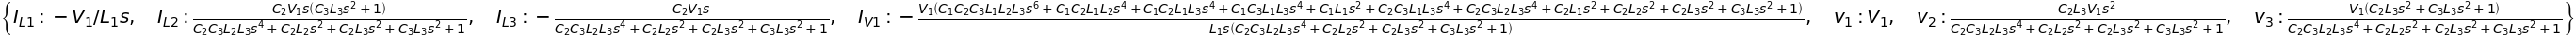

In [50]:
solve(equ_p1,[v1, v2, v3, I_V1, I_L1, I_L2, I_L3])

In [52]:
element_values = {L1:L1p,C1:C1p,C2:C2p,L2:L2p,L3:L1p,C3:C1p}

Sustituting actual value for the circuit elments, we get:

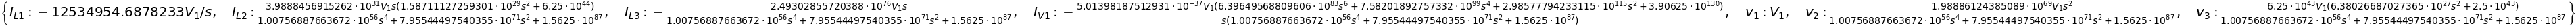

In [53]:
# find solution
u_p1 = solve(equ_p1.subs(element_values),[v1, v2, v3, I_V1, I_L1, I_L2, I_L3])
u_p1

$z_{11} = \frac {V_1}{I_1} \text{  when  } I_2=0$  

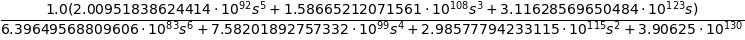

In [54]:
z11 = -u_p1[v1]/u_p1[I_V1]
z11.simplify()

$z_{21} = \frac {V_2}{I_1} \text{  when  } I_2=0$  

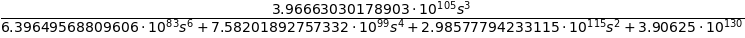

In [55]:
z21 = -u_p1[v2]/u_p1[I_V1]
z21.simplify()

## Find z12 & z22
To find $z_{12}$ and $z_{22}$, remove V1 from net list by commenting out the V1 line in the netlist. This will make $I_1$ equal to zero. $z_{12}$ is equal to $\frac{V_1}{I_2}\text{  when  }I_1=0$ and $z_{22}$ is equal to $\frac{V_2}{I_2}\text{  when  }I_1=0$.  

The net list below was run through the NMA code to generate the circuit equations.

Remove V1 from net list.
~~~
*V1 1 0 1
V2 2 0 1
L1 0 1 1
L2 1 3 1
L3 0 2 1
C1 1 0 1
C2 3 2 1
C3 2 0 1
~~~

The circuit equations generated by the MNA python code.
~~~
[[Eq(C1*s*v1 - I_L1 + I_L2, 0)],
[Eq(-C2*s*v3 - I_L3 + I_V2 + v2*(C2*s + C3*s), 0)],
[Eq(-C2*s*v2 + C2*s*v3 - I_L2, 0)],
[Eq(v2, V2)],
[Eq(-I_L1*L1*s - v1, 0)],
[Eq(-I_L2*L2*s + v1 - v3, 0)],
[Eq(-I_L3*L3*s - v2, 0)]]
~~~

In [56]:
# declare the following symbols
V2, L2, I_L2, v2, v1, C1, C3, L1, v3, I_L3, s, C2, L3, I_V2, I_L1 = symbols('V2 L2 I_L2 v2 v1 C1 C3 L1 v3 I_L3 s C2 L3 I_V2 I_L1')

# use the equations generated by nodal analysis
equ_p2 = Matrix(
    [[Eq(C1*s*v1 - I_L1 + I_L2, 0)],
    [Eq(-C2*s*v3 - I_L3 + I_V2 + v2*(C2*s + C3*s), 0)],
    [Eq(-C2*s*v2 + C2*s*v3 - I_L2, 0)],
    [Eq(v2, V2)],
    [Eq(-I_L1*L1*s - v1, 0)],
    [Eq(-I_L2*L2*s + v1 - v3, 0)],
    [Eq(-I_L3*L3*s - v2, 0)]])
equ_p2

⎡          C₁⋅s⋅v₁ - I_L1 + I_L2 = 0          ⎤
⎢                                             ⎥
⎢-C₂⋅s⋅v₃ - I_L3 + I_V2 + v₂⋅(C₂⋅s + C₃⋅s) = 0⎥
⎢                                             ⎥
⎢        -C₂⋅s⋅v₂ + C₂⋅s⋅v₃ - I_L2 = 0        ⎥
⎢                                             ⎥
⎢                   v₂ = V₂                   ⎥
⎢                                             ⎥
⎢             -I_L1⋅L₁⋅s - v₁ = 0             ⎥
⎢                                             ⎥
⎢          -I_L2⋅L₂⋅s + v₁ - v₃ = 0           ⎥
⎢                                             ⎥
⎣             -I_L3⋅L₃⋅s - v₂ = 0             ⎦

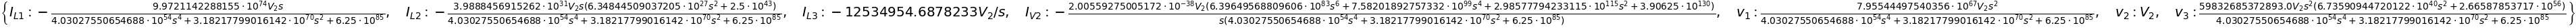

In [57]:
# find symbolic solution
u_p2 = solve(equ_p2.subs(element_values),[v1, v2, v3, I_V2, I_L1, I_L2, I_L3])
u_p2

$z_{12} = \frac {V_1}{I_2} \text{  when  } I_1=0$ 

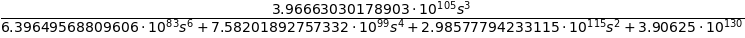

In [58]:
z12 = -u_p2[v1]/u_p2[I_V2]
z12.simplify()

$z_{22} = \frac {V_2}{I_2} \text{  when  } I_1=0$  

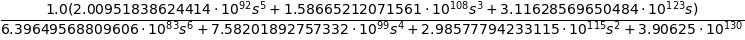

In [59]:
z22 = -u_p2[v2]/u_p2[I_V2]
z22.simplify()

displaying  the z-parameter matrix

In [60]:
Matrix([[z11,z21],[z12,z22]])

⎡                         ⎛                      4                         2  
⎢   1.9944228457631e+36⋅s⋅⎝1.00756887663672e+56⋅s  + 7.95544497540355e+71⋅s  +
⎢─────────────────────────────────────────────────────────────────────────────
⎢                      6                         4                          2 
⎢6.39649568809606e+83⋅s  + 7.58201892757332e+99⋅s  + 2.98577794233115e+115⋅s  
⎢                                                                             
⎢                                                         3                   
⎢                                  3.96663030178903e+105⋅s                    
⎢─────────────────────────────────────────────────────────────────────────────
⎢                      6                         4                          2 
⎣6.39649568809606e+83⋅s  + 7.58201892757332e+99⋅s  + 2.98577794233115e+115⋅s  

           ⎞                                                             3    
 1.5625e+87⎠                                      3

The complete z-paramter matrix is shown above. It's kind of interesting that the exponents on many of the cooefficients are so large. Using the SymPy function lambdify to turn the symbolic expression into a function.

In [61]:
func_z11_s = lambdify(s, z11)
func_z12_s = lambdify(s, z12) 
func_z21_s = lambdify(s, z21) 
func_z22_s = lambdify(s, z22) 

The input impedance of a two-port network is given by:

$Z_{in}=Z_{11}-\frac{Z_{12}Z_{21}}{Z_{22}+Z_{L}}$

where $Z_{L}$ is the impedance of the load connected to port two.

Similarly, the output impedance is given by:

$Z_{out}=Z_{22}-\frac{Z_{12}Z_{21}}{Z_{11}+Z_{S}}$

where $Z_{S}$ is the impedance of the source connected to port one.

Voltage gain  
$K_v=\frac{Z_{21}Z_{L}}{\Delta _Z+Z_{11}Z_L}$

In [62]:
# set the source and load impedance
Zl = Z
Zs = Z

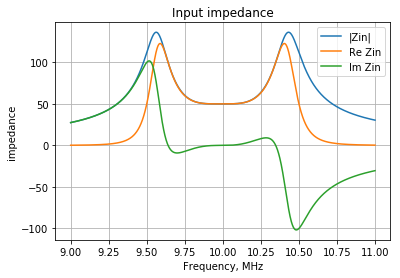

In [67]:
w = np.linspace(9e6*2*np.pi, 11e6*2*np.pi, 2000, endpoint=True)
#w = np.linspace(8e6*2*np.pi, 12e6*2*np.pi, 2000, endpoint=True)

plt.title('Input impedance')

plt.plot(w/(2*np.pi)/1e6, np.abs(func_z11_s(1j*w)-(func_z12_s(1j*w)*func_z21_s(1j*w))/(func_z22_s(1j*w)+Zl)),'-',label='|Zin|')
plt.plot(w/(2*np.pi)/1e6, np.real(func_z11_s(1j*w)-(func_z12_s(1j*w)*func_z21_s(1j*w))/(func_z22_s(1j*w)+Zl)),'-',label='Re Zin')
plt.plot(w/(2*np.pi)/1e6, np.imag(func_z11_s(1j*w)-(func_z12_s(1j*w)*func_z21_s(1j*w))/(func_z22_s(1j*w)+Zl)),'-',label='Im Zin')
#plt.plot(w/(2*np.pi)/1e6, np.abs(func_z22_s(1j*w)-(func_z12_s(1j*w)*func_z21_s(1j*w))/(func_z11_s(1j*w)+Zs)),'-',label='|Zout|')

plt.ylabel('impedance')
plt.xlabel('Frequency, MHz')
plt.legend()
plt.grid()
plt.show()

The plot above shows the magnitude of the input impedance (in blue), the real part of the input impedance (in orange) and the imaginary part of the input impedance (in green). Near 10Hz, the magnitude and real part of the input impedance is 50 ohms and the imaginary part is about zero. This shows that the design equations produced the desired results. The input impedance bandwidth of the filter is about 1 MHz.

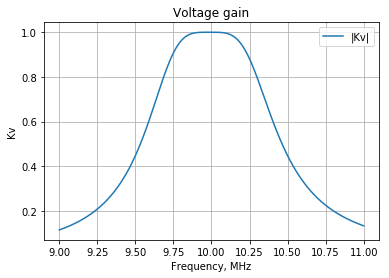

In [68]:
#w = np.linspace(8.5e6*2*np.pi, 11.5e6*2*np.pi, 2000, endpoint=True)
#w = np.linspace(8e6*2*np.pi, 12e6*2*np.pi, 1000, endpoint=True)

Ki = (-func_z21_s(1j*w))/( func_z22_s(1j*w)+Zl)
Kv = (func_z21_s(1j*w)*Zl)/(func_z11_s(1j*w)*func_z22_s(1j*w) - func_z12_s(1j*w)*func_z21_s(1j*w) + func_z11_s(1j*w)*Zl)

plt.title('Voltage gain')

#plt.plot(w/(2*np.pi)/1e6, np.abs(Ki),'-',label='|Ki|')
#plt.plot(w/(2*np.pi)/1e6, np.real(Ki),'-',label='Re Ki')
#plt.plot(w/(2*np.pi)/1e6, np.imag(Ki),'-',label='Im Ki')
plt.plot(w/(2*np.pi)/1e6, np.abs(Kv),'-',label='|Kv|')
#plt.plot(w/(2*np.pi)/1e6, np.real(Kv),'-',label='Re Kv')
#plt.plot(w/(2*np.pi)/1e6, np.imag(Kv),'-',label='Im Kv')

plt.ylabel('Kv')
plt.xlabel('Frequency, MHz')
plt.legend()
plt.grid()
plt.show()

The plot above shows the voltage gain of the filter (in blue) plotted from the z-parameters. The filter is centered at 10MHz and the bandwidth apears to be 1 MHz. 

## Convert z-paramters to s-parameters
Although applicable at any frequency, s-parameters are mostly used for networks operating at radio frequency (RF) and microwave frequencies. The s-parameters can be calculated from the z-parameters with the following formulas:

In [65]:
Z_o = 50 # characteristic impedance
#freq_list = np.linspace(9.5e6*2*np.pi, 10.5e6*2*np.pi, 1000, endpoint=True)
w = np.linspace(8e6*2*np.pi, 12e6*2*np.pi, 2000, endpoint=True)
s11 = np.zeros(len(w),dtype=complex)
s12 = np.zeros(len(w),dtype=complex)
s21 = np.zeros(len(w),dtype=complex)
s22 = np.zeros(len(w),dtype=complex)

for i in range(len(w)):
    del_z = (func_z11_s(1j*w[i])+Z_o)*(func_z22_s(1j*w[i])+Z_o)-func_z12_s(1j*w[i])*func_z21_s(1j*w[i])
    s11[i] = ((func_z11_s(1j*w[i])-Z_o)*(func_z22_s(1j*w[i])+Z_o)-func_z12_s(1j*w[i])*func_z21_s(1j*w[i]))/del_z
    s12[i] = (2*func_z12_s(1j*w[i])*Z_o)/del_z
    s21[i] = (2*func_z21_s(1j*w[i])*Z_o)/del_z
    s22[i] = ((func_z11_s(1j*w[i])+Z_o)*(func_z22_s(1j*w[i])-Z_o)-func_z12_s(1j*w[i])*func_z21_s(1j*w[i]))/del_z
    

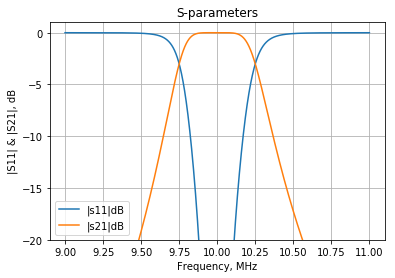

In [69]:
plt.title('S-parameters')
plt.plot(w/(2*np.pi)/1e6, 20*np.log10(np.abs(s11)),'-',label='|s11|dB')
#plt.plot(w/(2*np.pi)/1e6, 20*np.log10(np.abs(s12)),'-',label='|s12|dB')
plt.plot(w/(2*np.pi)/1e6, 20*np.log10(np.abs(s21)),'-',label='|s21|dB')
#plt.plot(w/(2*np.pi)/1e6, 20*np.log10(np.abs(s22)),'-',label='|s22|dB')

plt.ylabel('|S11| & |S21|, dB')
plt.xlabel('Frequency, MHz')
plt.ylim((-20,1))
plt.yticks(np.arange(-20, 1, 5))
#plt.xlim((-1,20))
#plt.xticks(np.arange(0, 20+1, 2.0))
plt.legend()
plt.grid()
plt.show()

The plot above shows the magnitudes in dB of the input reflection coefficient (in blue) and the forward voltage gain (in orange). 

The magnitude of the input reflection coefficient indicates the amount of energy reflected back to the source due to the impedance mismatch. The smaller the relfection coefficent the better the match, and in dB, large negative values are very small small numbers. A rule of thumb is that |S11| less than about -9.5 dB is a reasonable match, since this corresponds to about a 2:1 VSWR or a mismatch loss of about 0.5 dB. The frequency range over which this match occures is called the impedance bandwidth. 

The plot of |S21| of the shows the forward voltage gain of the filter in in dB. The filter was designed to be a band pass filter with a center frequency of 10 MHz, which it clearly shown in the plot. The plot is simular to what would been seen on a network analyzer. 

## Summery
In this notebook the paramaters for two port networks were generated from the circuit's netlist. Using python, the circuit equations were automatically generated by using modified nodal analysis, then SymPy was used to solve for the network currents and voltages. Z-paramters were calculated for the circuits, from which y and s parameters were generated. The z-paramters were used to generate input impedance and transfer functions.

This notebook had demonstrated that two port parameters can easily be generated from a circuits netlist with python. 